In [64]:
import pandas as pd
import torch
import numpy as np

dataset = pd.read_excel("Server_1_Training_Sets/cpu_usage.xlsx")
#dataset = pd.read_excel("Server_1_Training_Sets/ram_usage.xlsx")
#dataset = pd.read_excel("Server_1_Training_Sets/network_usage.xlsx")

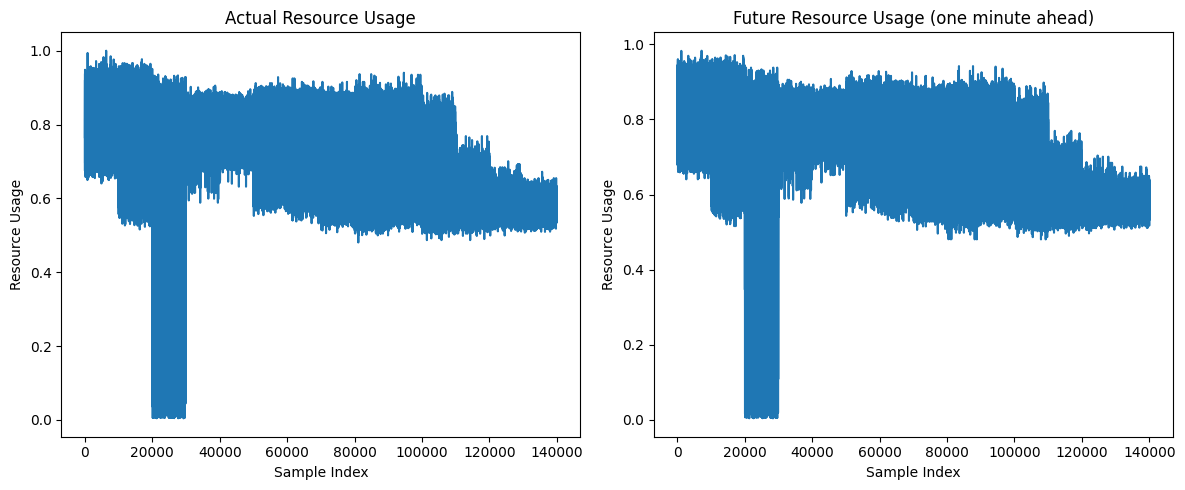

In [65]:
import matplotlib.pyplot as plt

#metric = "Network Usage"
metric = "Resource Usage"

# Cria o subplot com 1 linha e 2 colunas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plota dataset["X"] no primeiro subplot
ax1.plot(dataset["X"])
ax1.set_title(f'Actual {metric}')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel(metric)

# Plota dataset["y"] no segundo subplot
ax2.plot(dataset["y"])
ax2.set_title(f'Future {metric} (one minute ahead)')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel(metric)

# Exibe os gráficos
plt.tight_layout()
plt.show()
#plt.savefig(f"plots/{metric} Dataset.png", dpi=300)

In [66]:
X = np.array(dataset["X"]).reshape(-1, 1)
y = np.array(dataset["y"]).reshape(-1, 1)

In [67]:
X_data = torch.tensor(X)
y_data = torch.tensor(y)

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(X_data, y_data, test_size=0.6, random_state=2024, shuffle=True) # 0.6 para treino
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, test_size=0.5, random_state=2024, shuffle=True) # 0.3 para validação e 0.3 para teste

In [69]:
X_data = X_train
y_data = y_train

In [70]:
len(X_data)

56005

In [71]:
len(X_val)

42004

In [72]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import os

class CPULSTM(nn.Module):
    def __init__(self):
        super(CPULSTM, self).__init__()
        
        self.hidden_size = 256
        self.num_layers = 3
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        
        self.batch_norm1 = nn.BatchNorm1d(self.hidden_size * 2)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(2 * self.hidden_size, self.hidden_size)
        
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size)
        self.relu2 = nn.ReLU()
        self.linear2 = nn.Linear(self.hidden_size, self.hidden_size // 2)
        
        self.batch_norm3 = nn.BatchNorm1d(self.hidden_size // 2)
        self.relu3 = nn.ReLU()
        self.linear3 = nn.Linear(self.hidden_size // 2, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        
        residual = x
        
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.linear1(x)
        
        residual = self.linear1(residual)
        
        x = x + residual
        residual = x
        
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.linear2(x)
        
        residual = self.linear2(residual)
        
        x = x + residual
        residual = x
        
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.linear3(x)
        
        return x
    
def init_weights(module):
    if isinstance(module, nn.LSTM):
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
    
model = CPULSTM()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = Adam(model.parameters(), lr=1e-3)

loss_fn = nn.MSELoss()

X_data_tensor = torch.tensor(X_data, dtype=torch.float32).clone().detach()
y_data_tensor = torch.tensor(y_data, dtype=torch.float32).clone().detach()

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).clone().detach()
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).clone().detach()

dataset = TensorDataset(X_data_tensor, y_data_tensor)
data_loader = DataLoader(dataset, shuffle=True, batch_size=1024)

model.to(device)

if not os.path.exists('models'):
    os.makedirs('models')

n_epochs = 100
max_consecutive_increases = 10
train_rmse_history = []
val_rmse_history = []
consecutive_increases = 0
best_rmse = float('inf')
best_epoch = 0

for epoch in range(n_epochs):
    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        model.eval()
        
        # Erro treino
        y_pred = model(X_data_tensor.to(device))
        train_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_data_tensor).item())
        
        # Erro validação
        y_val_pred = model(X_val_tensor.to(device))
        val_rmse = np.sqrt(loss_fn(y_val_pred.cpu(), y_val_tensor).item())
        
        model.train()
    
    train_rmse_history.append(train_rmse)
    val_rmse_history.append(val_rmse)
    print(f"Epoch {epoch}: train RMSE {train_rmse} val RMSE: {val_rmse}")
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_epoch = epoch
        checkpoint_path = f"models/model_best_rmse.pt"
        torch.save(model, checkpoint_path)
        print(f"Modelo salvo com RMSE: {best_rmse} na época {epoch}")
    
    with open("models/performance.txt", "w") as f:
        f.write(f"Best Model Val RMSE: {best_rmse}\nModel Best Val Epoch: {best_epoch}\nModel Train RMSE History: {train_rmse_history}\nModel Val RMSE History: {val_rmse_history}")

    if len(val_rmse_history) > 1 and val_rmse > val_rmse_history[-2]:
        consecutive_increases += 1
    else:
        consecutive_increases = 0
    
    if consecutive_increases >= max_consecutive_increases:
        print(f"Early stopping at epoch {epoch} due to consecutive increases in RMSE.")
        break
    
print(f"Melhor RMSE encontrado: {best_rmse} na época {best_epoch}")

/tmp/ipykernel_48903/3003365794.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_data_tensor = torch.tensor(X_data, dtype=torch.float32).clone().detach()
/tmp/ipykernel_48903/3003365794.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data_tensor = torch.tensor(y_data, dtype=torch.float32).clone().detach()
/tmp/ipykernel_48903/3003365794.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.float32).clone().detach()
/tmp/ipykernel_48903/3003365794.py:78: UserWarning: To copy constr

Epoch 0: train RMSE 0.11469623618802749 val RMSE: 0.11427579640416834
Modelo salvo com RMSE: 0.11427579640416834 na época 0
Epoch 1: train RMSE 0.307612125415629 val RMSE: 0.3078538498964728
Epoch 2: train RMSE 0.2103829865993737 val RMSE: 0.2099234702813111
Epoch 3: train RMSE 0.2578457464109182 val RMSE: 0.2582360891517356
Epoch 4: train RMSE 0.11519556685167692 val RMSE: 0.11532885912894246
Epoch 5: train RMSE 0.1584492875779839 val RMSE: 0.15849050863394737
Epoch 6: train RMSE 0.22334431692563592 val RMSE: 0.22331414151969656
Epoch 7: train RMSE 0.09679640361895868 val RMSE: 0.09682887059623804
Modelo salvo com RMSE: 0.09682887059623804 na época 7
Epoch 8: train RMSE 0.07092246746543576 val RMSE: 0.0707284689629141
Modelo salvo com RMSE: 0.0707284689629141 na época 8
Epoch 9: train RMSE 0.08946308576106408 val RMSE: 0.08954681171367741
Epoch 10: train RMSE 0.08500917479404523 val RMSE: 0.08519944333569865
Epoch 11: train RMSE 0.04714705327316287 val RMSE: 0.047018588700861466
Model

# Training Evolution

/tmp/ipykernel_48903/1148405440.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


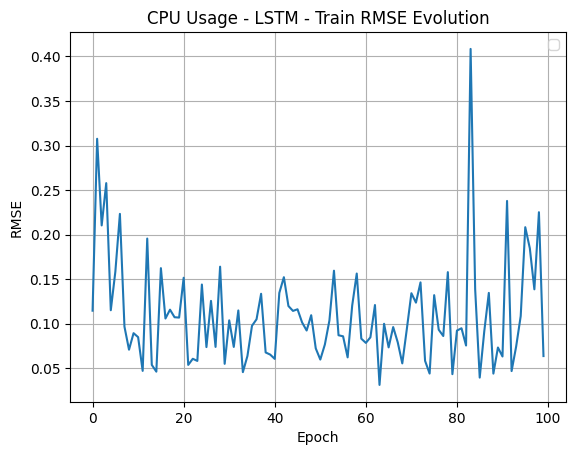

In [73]:
import matplotlib.pyplot as plt

#metric_name = "CPU Usage"
metric_name = "Resource Usage"
model_name = "LSTM"

plt.plot(train_rmse_history)
plt.title(f"{metric_name} - {model_name} - Train RMSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()
#plt.savefig(f"plots/{metric_name} {model_name}.png", dpi=300)

# Model Evaluation

In [74]:
model_name = "model_best_rmse.pt"

model = torch.load(f"models/{model_name}")

model.to(device)

# Preparar X_test e y_test para o dispositivo
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Fazer previsões com o modelo
with torch.no_grad():  # Desativa o cálculo do gradiente durante a avaliação
    y_pred = model(X_test_tensor)

# Calcular o RMSE
y_pred = y_pred.cpu().numpy()  # Move as previsões de volta para a CPU e converte para numpy
y_test = y_test_tensor.cpu().numpy()  # Move os valores reais de volta para a CPU e converte para numpy

rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

print(f"RMSE no Conjunto de Teste: {rmse}")
print(f"Total de Amostras de Teste: {len(X_test_tensor)}")

with open("models/performance.txt", "a") as f:
    f.write(f"\nModel Test RMSE: {rmse}")

/tmp/ipykernel_48903/410293736.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"models/{model_name}")
/tmp/ipykernel_48903/410293736.py:8: UserWarnin

RMSE no Conjunto de Teste: 0.24020908772945404
Total de Amostras de Teste: 42005


# Anomalies

Anomalias detectadas nos índices: [  700  1605  1624  2836  2917  3365  4380  4419  4942  5282  5451  5743
  5944  6389  6420  7228  8865  8910  9451 10050 11419 12254 13533 13716
 15300 16119 16274 18362 18651 19155 19578 19857 20012 20144 20466 21163
 21908 22683 22973 23658 24402 24495 24831]


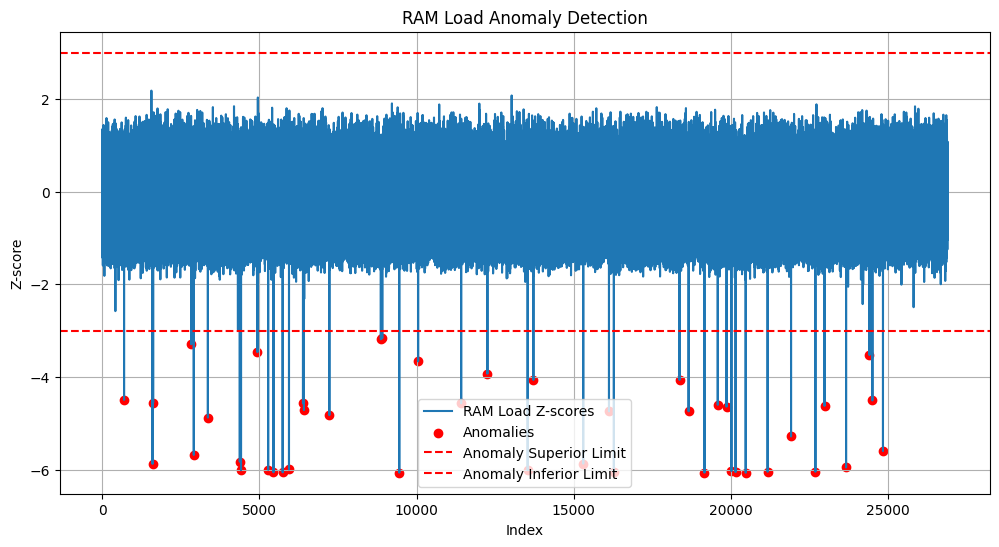

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que X_data seja um tensor do PyTorch
X_data_np = X_data.numpy()

# Calculando a média e o desvio padrão da série
mean = np.mean(X_data_np)
std_dev = np.std(X_data_np)

# Convertendo todos os dados para z-scores
z_scores = (X_data_np - mean) / std_dev

# Definindo um limite para detecção de anomalias (por exemplo, z-scores maior que 3)
anomaly_cutoff = 3

# Identificando anomalias com base nos z-scores
anomalies = np.where(np.abs(z_scores) > anomaly_cutoff)[0]

print("Anomalias detectadas nos índices:", anomalies)

m = "RAM Load"

# Plotando a série temporal com z-scores e destacando as anomalias
plt.figure(figsize=(12, 6))
plt.plot(z_scores, label=f'{m} Z-scores')
plt.scatter(anomalies, z_scores[anomalies], color='red', label='Anomalies')
plt.axhline(y=anomaly_cutoff, color='r', linestyle='--', label='Anomaly Superior Limit')
plt.axhline(y=-anomaly_cutoff, color='r', linestyle='--', label='Anomaly Inferior Limit')
plt.xlabel('Index')
plt.ylabel('Z-score')
plt.title(f'{m} Anomaly Detection')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Removendo as anomalias com z-scores menores que -3
#indices_no_neg_anomalies = np.where(z_scores >= -2)[0]

# Criando X_data_no_neg_anomalies com os mesmos índices
#X_data_no_neg_anomalies = X_data[indices_no_neg_anomalies]

# Criando y_data_no_neg_anomalies com os mesmos índices de X_data
#y_data_no_neg_anomalies = y_data[indices_no_neg_anomalies]

In [9]:
# Encontrando o menor valor dentre as anomalias identificadas
min_anomaly = np.min(X_data_np[anomalies])

print("Minimum Anomaly:", min_anomaly)

Minimum Anomaly: 0.7
